In [1]:
import gooseberry as gs
from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn 
import torch.optim as optim

import matplotlib.pyplot as plt 
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
import seaborn as sns
from tools import BlindColours, zero_balanced_weights

(array([[-0.92135369, -0.4028982 ,  0.46242697],
       [ 0.0092948 , -0.72487315,  0.19554125],
       [-0.22115598,  0.42228203,  0.3632095 ]]), array([[-1.89616076, -0.13856488, -0.28531504],
       [ 0.0260294 ,  1.69037531,  0.14564765],
       [-0.20997559, -0.31988994,  1.63452438]]), array([[2.31264725, 0.        , 0.        ],
       [0.        , 1.44028121, 0.        ],
       [0.        , 0.        , 0.43109791]]), array([[-2.41513463e+00,  1.05471187e-15,  2.49800181e-16],
       [ 1.05471187e-15, -2.41513463e+00, -2.55351296e-15],
       [ 2.49800181e-16, -2.55351296e-15, -2.41513463e+00]]))


In [2]:
class QQT_new:
    def __init__(self, init_w1, init_w2, X, Y, weights_only=False):
        
        self.weights_only = weights_only
        self.batch_size = X.shape[0]

        self.input_dim = X.shape[1]
        self.output_dim = Y.shape[1]
        
        sigma_yx_tilde = 1 / self.batch_size * Y.T @ X 

        U_, S_, Vt_= np.linalg.svd(sigma_yx_tilde)
        V_ = Vt_.T 

        self.dim_diff = np.abs(self.input_dim - self.output_dim)

        if self.input_dim < self.output_dim:
            U_hat = U_[:, self.input_dim:]
            V_hat = np.zeros((self.input_dim, self.dim_diff))
            U_ = U_[:, :self.output_dim]

        elif self.input_dim > self.output_dim:
            U_hat = np.zeros((self.output_dim, self.dim_diff))
            V_hat = V_[:, self.output_dim:]
            V_ = V_[:, :self.output_dim]

        else:
            U_hat  = None 
            V_hat = None

        self.U_hat = U_hat 
        self.V_hat = V_hat 
        self.U_, self.S_, self.V_ = U_, np.diag(S_), V_

        U, S, Vt  = np.linalg.svd(init_w2 @ init_w1, full_matrices=False)
        self.U, self.S, self.V = U, S, Vt.T 

        self.B = self.U.T @ self.U_ + self.V.T @ self.V_ 
        self.C = self.U.T @ self.U_ - self.V.T @ self.V_



        ##CHECK THAT B IS NON SINGULAR
        self.t = 0

    def forward(self, learning_rate):
        #performs forward for one timestep

        time_step = self.t * learning_rate

        i = np.identity(self.input_dim) if self.input_dim < self.output_dim else np.identity(self.output_dim) 

        e_st_inv = np.diag(np.exp(-1. * np.diag(self.S_) * time_step))
        e_2st_inv = np.diag(np.exp(-2. * np.diag(self.S_) * time_step))

        B_inv = np.linalg.inv(self.B)

        Sinv = np.diag(1. / self.S)
        S_inv = np.diag(1. / np.diag(self.S_))

        # if self.t==10:
        #     print('QQT changed version:')
        #     print('V_: ', self.V_)
        #     print('U_: ', self.U_)
        #     print('e_st_inv: ', e_st_inv)
        #     print('C: ', self.C)
        #     print('B_inv: ', B_inv)
        #     print('V_hat: ', self.V_hat)
        #     print('V:  ', self.V)
        #     print('U_hat: ', self.U_hat)
        #     print('U:  ', self.U)

        if self.U_hat is None and self.V_hat is None:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv),
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv)
            ])
            center_right = 0.

        else:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.V_hat@self.V_hat.T @ self.V @ B_inv.T @ e_st_inv,
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.U_hat@self.U_hat.T @ self.U @ B_inv.T @ e_st_inv
            ])
            center_right = 4 * time_step * e_st_inv @ B_inv @ (self.V.T @ self.V_hat @ self.V_hat.T @ self.V + self.U.T @ self.U_hat @ self.U_hat.T @ self.U) @ B_inv.T @ e_st_inv

        center_left = 4. * e_st_inv @ B_inv @ Sinv @ B_inv.T @ e_st_inv 
        center_center = (i - e_2st_inv) @ S_inv- e_st_inv @ B_inv @ self.C @ (e_2st_inv - i) @ S_inv @ self.C.T @ B_inv.T @ e_st_inv
        
        # if self.t==1:
        #     print('New Version center_center variables: ')
        #     print('i: ', i)
        #     print('e_2st_inv: ', e_2st_inv)
        #     print('S_inv: ', S_inv)
        #     print('e_st_inv: ', e_st_inv)
        #     print('B_inv: ', B_inv)
        #     print('C: ', self.C)

        center = np.linalg.inv(center_left + center_center + center_right)

        qqt = Z @ center @ Z.T 
        if self.weights_only:
            qqt = qqt[self.input_dim:, :self.input_dim] 

        self.t+=1
        return qqt 

In [8]:
class LinearNetwork:
    def __init__(self, in_dim, hidden_dim, out_dim, init_w1 = None, init_w2 = None):

        if init_w1 is not None and init_w2 is not None:
            self.W1 = init_w1.copy()
            self.W2 = init_w2.copy()
        else:
            self.W1 = np.random.randn(hidden_dim, in_dim)
            self.W2 = np.random.randn(out_dim, hidden_dim)

    def forward(self, x): 
        self.z = self.W2 @ self.W1 @ x
        return self.z

    def backward(self, x, y, learning_rate):

        self.forward(x)
        dW1 = 1/x.shape[1] *self.W2.T @ (self.z-y) @ x.T 
        dW2 = 1/x.shape[1] * (self.z - y) @ x.T @ self.W1.T

        # print('dW1: ', np.linalg.norm(dW1))
        # print('dW2: ', np.linalg.norm(dW2))

        self.W2 -= learning_rate * dW2
        self.W1 -= learning_rate * dW1


    def train(self, X_train, Y_train, epochs, learning_rate):
        w1s = []
        w2s = []
        print('X_train shape: ', X_train.shape)
        print('Y_train shape: ', Y_train.shape)
        losses = []
        print('epochs: ', epochs)
        for _ in range(epochs):
            loss = np.mean((self.forward(X_train) - Y_train) ** 2)
            losses.append(loss)
            w1s.append(self.W1.copy())
            w2s.append(self.W2.copy())
            self.backward(X_train, Y_train, learning_rate)
            # print(f"Epoch {epoch+1}/{epochs}, Loss: {loss}")

        return w1s, w2s, losses

In [4]:
def whiten(X):

    scaler = StandardScaler()

    X_standardised = scaler.fit_transform(X)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_standardised)

    print('explained variance: ', pca.explained_variance_)
    X_whitened = X_pca / np.sqrt(pca.explained_variance_)

    X_whitened = np.sqrt(X.shape[0] / (X.shape[0] - 1)) * X_whitened

    return X_whitened

def get_random_regression_task(batch_size, in_dim, out_dim):
    X = np.random.randn(batch_size, in_dim)
    Y = np.random.randn(batch_size, out_dim)
    X_whitened = whiten(X)

    return X_whitened, Y

X_train shape:  (5, 10)
Y_train shape:  (2, 10)
epochs:  400
X_train shape:  (5, 10)
Y_train shape:  (2, 10)
epochs:  400
X_train shape:  (5, 10)
Y_train shape:  (2, 10)
epochs:  400


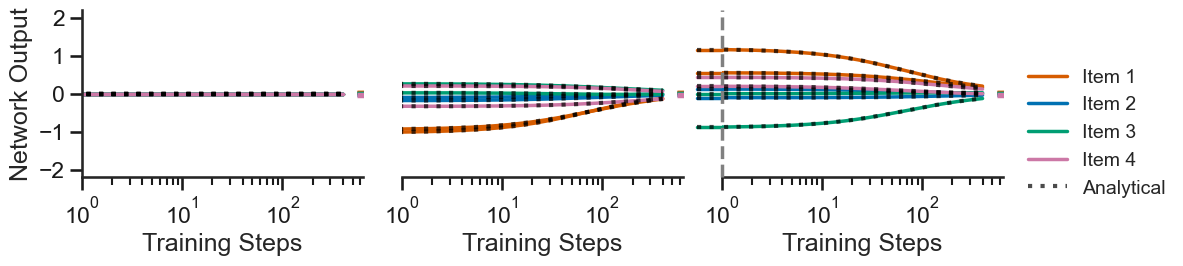

In [20]:
np.random.seed(1)

in_dim = 5
hidden_dim = 10
out_dim = 2

batch_size = 10
learning_rate = 0.01
training_steps = 400

plot_items_n = 4
blind_colours = BlindColours().get_colours()

# init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, 0.07)


train, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])

fig, axs = plt.subplots(1, 3, figsize=(12, 3.))

for i, initial_scale in enumerate([0.01, .25, .25]):
    task = gs.tasks.FullBatchLearning(train)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)

    losses = []
    ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]
    
    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        losses.append(loss)
        ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])
    

    X, Y = train(None)
    # X, Y = get_random_regression_task(batch_size, in_dim, out_dim)

    X, Y = X.copy(), Y.copy()

    
    model = LinearNetwork(in_dim = in_dim, hidden_dim=hidden_dim, out_dim=out_dim, init_w1=init_w1.copy(), init_w2=init_w2.copy())
    
    
    w1s, w2s, losses = model.train(X.T.copy(), Y.T.copy(), training_steps, learning_rate)
    analytical = np.array([w2 @ w1 for (w2, w1) in zip(w2s, w1s)])
    analytical = np.expand_dims(ws, axis=1)
    analytical = analytical[:-1]


    # analytical = QQT(init_w1.copy(), init_w2.copy(), X.T, Y.T, True)
    # analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    
    

    outputs = (np.asarray(ws)[:, 0, :, :] @ X[:plot_items_n].T)
    # outputs = (np.asarray(ws)[:, :, 0] @ X[:plot_items_n].T)
    for color, output in zip(blind_colours, outputs.T):
        for val in output:
            axs[i].plot(val, c=color, lw=2.5)
    axs[i].plot((analytical @ X[:plot_items_n].T).reshape(training_steps, -1), lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2))) # (0, (3, 4, 3, 1))
    
    for color, target in zip(blind_colours, Y[:plot_items_n]):
        for value in target:
            axs[i].scatter(training_steps * 1.6, value, marker="_", color=color, lw=2.5)
    
    axs[i].set_xlim(1, training_steps * 1.6)
    axs[i].set_ylim([-2.2, 2.2])
    
    axs[i].set_xscale("log")
    
    axs[i].set_xlabel("Training Steps")
    if i == 0:
        sns.despine(ax=axs[i])
        axs[i].set_ylabel("Network Output")
        axs[i].set_yticks([-2, -1., 0., 1., 2])
    else:
        sns.despine(ax=axs[i], left=True)
        axs[i].set_yticks([])

first_task = outputs[1]
rng = np.linspace(0.57, 1., 10)
for color, output in zip(blind_colours, first_task.T):
    for val in output:
        axs[2].plot(rng, [val]*10, c=color, lw=2.5, clip_on=False, zorder=1)
        axs[2].plot(rng, [val]*10, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), clip_on=False, zorder=2)
axs[2].axvline(1., linestyle="--", c="grey", lw=2.5, clip_on=False, zorder=3)

for n, (color) in enumerate(blind_colours[:plot_items_n]):
    axs[2].plot(-5, -5, c=color, lw=2.5, label=f"Item {n + 1}")
axs[2].plot(-5, -5, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), label="Analytical")

fig.legend(loc=7, fontsize=14, frameon=False)
fig.tight_layout()
fig.subplots_adjust(right=0.85)

fig.savefig("./figures/figure-1_b-c-d.svg")

In [ ]:
diffs_l = [np.linalg.norm(w - a) for (w, a) in zip(ws, analytical)]

In [18]:
diffs_lukas = [np.linalg.norm(w - a) for (w, a) in zip(ws, analytical)]

In [ ]:
print('w1: ', init_w1)

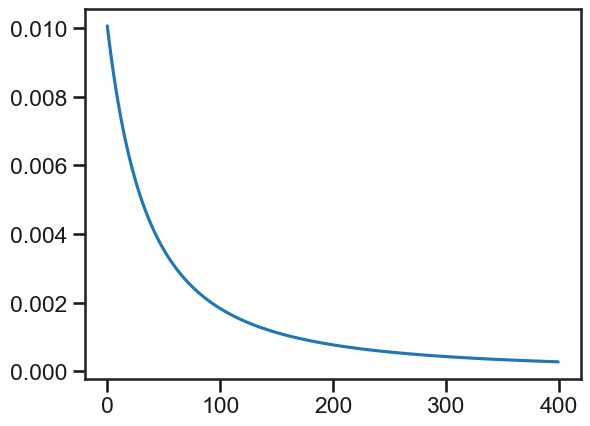

In [21]:
plt.plot(diffs_lukas)

In [145]:
print('x: ', X)
print(('y: ', Y))


x:  [[-0.6809496  -1.8006924  -0.64563125  0.41735595  1.5920889 ]
 [ 1.2864076  -0.6470147  -0.8013514  -0.55148906 -1.9888552 ]
 [-0.0453576   0.31852305  1.6821109   1.3354625  -0.38260198]
 [ 2.227024   -0.0131458  -0.3563922   0.28951746  0.9655614 ]
 [-1.3704554   0.20065999 -1.1828825  -0.8296731  -0.81035894]
 [-0.29547843 -0.23439132  0.23412952  1.5816791  -0.7988093 ]
 [-0.4106446  -1.3750403   1.1866329  -1.2703744   0.05847262]
 [-0.87806404  1.0428503  -0.37677094  0.70222294 -0.04921253]
 [ 0.06564585  1.349281   -1.08371    -0.14632052  0.96288574]
 [ 0.10187231  1.1589705   1.3438667  -1.5283813   0.45082915]]
('y: ', Array([[ 0.05597696,  0.03992401],
       [-0.03353213, -0.01412801],
       [ 0.01598432,  0.0299868 ],
       [-0.06458099, -0.01332625],
       [ 0.02877785, -0.01763283],
       [ 0.04040009,  0.03361403],
       [ 0.01128944,  0.01708413],
       [ 0.02274386, -0.00440819],
       [-0.02594368, -0.03580576],
       [-0.05111574, -0.03530794]], dtype=

explained variance:  [2.47958049 1.28523771 0.85466085 0.70032747 0.23574903]
y:  [[ 1.6169496   0.50274088]
 [ 1.55880554  0.1094027 ]
 [-1.2197444   2.44936865]
 [-0.54577417 -0.19883786]
 [-0.7003985  -0.20339445]
 [ 0.24266944  0.20183018]
 [ 0.66102029  1.79215821]
 [-0.12046457 -1.23312074]
 [-1.18231813 -0.66575452]
 [-1.67419581  0.82502982]]
X_train shape:  (5, 10)
Y_train shape:  (2, 10)
epochs:  400
explained variance:  [2.38072798 1.5674231  0.89577534 0.50050409 0.21112505]
y:  [[-0.18657899 -0.05682448]
 [ 0.49233656 -0.68067814]
 [-0.08450803 -0.29736188]
 [ 0.417302    0.78477065]
 [-0.95542526  0.58591043]
 [ 2.06578332 -1.47115693]
 [-0.8301719  -0.8805776 ]
 [-0.27909772  1.62284909]
 [ 0.01335268 -0.6946936 ]
 [ 0.6218035  -0.59980453]]
X_train shape:  (5, 10)
Y_train shape:  (2, 10)
epochs:  400
explained variance:  [3.05426227 1.41794191 0.50488162 0.44598655 0.13248322]
y:  [[-0.55749472  0.93916874]
 [-1.94332341  0.35249436]
 [-0.23643695  0.7278135 ]
 [ 0.5150

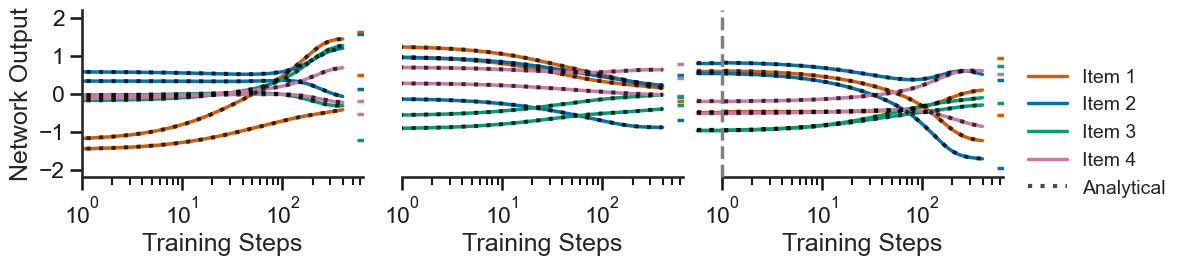

In [22]:
np.random.seed(1)

in_dim = 5
hidden_dim = 10
out_dim = 2

batch_size = 10
learning_rate = 0.01
training_steps = 400

plot_items_n = 4
blind_colours = BlindColours().get_colours()

# init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, 0.35)


train, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])

fig, axs = plt.subplots(1, 3, figsize=(12, 3.))

for i, initial_scale in enumerate([0.01, .25, .25]):
    # task = gs.tasks.FullBatchLearning(train)
    # optimiser = gs.GradientDescent(learning_rate)
    # loss = gs.MeanSquaredError()

    # init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)
    
    # mlp = gs.Network([
    #     gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
    #     gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    # ])

    # trainer = gs.Trainer(task, mlp, loss, optimiser)
    # state, params = gs.assemble(1)

    # losses = []
    # ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]
    
    # for training_step in range(training_steps):
    #     state, params, loss = trainer(state, params)
    #     losses.append(loss)
    #     ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])
    

    # X, Y = train(None)
    X, Y = get_random_regression_task(batch_size, in_dim, out_dim)

    X, Y = X.copy(), Y.copy()

    print('y: ', Y)

    
    model = LinearNetwork(in_dim = in_dim, hidden_dim=hidden_dim, out_dim=out_dim, init_w1=init_w1.copy(), init_w2=init_w2.copy())
    
    
    w1s, w2s, losses = model.train(X.T.copy(), Y.T.copy(), training_steps, learning_rate)
    ws = np.array([w2 @ w1 for (w2, w1) in zip(w2s, w1s)])
    ws = np.expand_dims(ws, axis=1)


    analytical = QQT_new(init_w1.copy(), init_w2.copy(), X, Y, True)
    analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    
    

    outputs = (np.asarray(ws)[:, 0, :, :] @ X[:plot_items_n].T)
    # outputs = (np.asarray(ws)[:, :, 0] @ X[:plot_items_n].T)
    for color, output in zip(blind_colours, outputs.T):
        for val in output:
            axs[i].plot(val, c=color, lw=2.5)
    axs[i].plot((analytical @ X[:plot_items_n].T).reshape(training_steps, -1), lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2))) # (0, (3, 4, 3, 1))
    
    for color, target in zip(blind_colours, Y[:plot_items_n]):
        for value in target:
            axs[i].scatter(training_steps * 1.6, value, marker="_", color=color, lw=2.5)
    
    axs[i].set_xlim(1, training_steps * 1.6)
    axs[i].set_ylim([-2.2, 2.2])
    
    axs[i].set_xscale("log")
    
    axs[i].set_xlabel("Training Steps")
    if i == 0:
        sns.despine(ax=axs[i])
        axs[i].set_ylabel("Network Output")
        axs[i].set_yticks([-2, -1., 0., 1., 2])
    else:
        sns.despine(ax=axs[i], left=True)
        axs[i].set_yticks([])

first_task = outputs[1]
rng = np.linspace(0.57, 1., 10)
for color, output in zip(blind_colours, first_task.T):
    for val in output:
        axs[2].plot(rng, [val]*10, c=color, lw=2.5, clip_on=False, zorder=1)
        axs[2].plot(rng, [val]*10, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), clip_on=False, zorder=2)
axs[2].axvline(1., linestyle="--", c="grey", lw=2.5, clip_on=False, zorder=3)

for n, (color) in enumerate(blind_colours[:plot_items_n]):
    axs[2].plot(-5, -5, c=color, lw=2.5, label=f"Item {n + 1}")
axs[2].plot(-5, -5, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), label="Analytical")

fig.legend(loc=7, fontsize=14, frameon=False)
fig.tight_layout()
fig.subplots_adjust(right=0.85)

fig.savefig("./figures/figure-1_b-c-d.svg")

In [10]:
print('x: ', X)
print(('y: ', Y))


x:  [[-0.6586278   0.24157555  1.7758182  -0.85971695 -0.8217812 ]
 [-1.5886624   0.61117375 -0.83087313  0.6919029  -0.3215904 ]
 [ 0.79351187  0.90071553  0.2383056  -1.2128754   0.25835067]
 [ 1.0486465   0.05551938  0.815052   -0.3306368   0.16250716]
 [ 0.90439403 -2.0449967  -0.3384631  -0.64533484  0.07239711]
 [ 0.6155843   1.3185438  -0.7816694   0.27953354  1.9878706 ]
 [-0.05219614 -0.4535778  -2.03633    -0.6614123  -1.05698   ]
 [-1.134155    0.58972293  0.16905622 -0.47950456 -0.45236433]
 [ 1.2241503   0.26732546  0.3444333   2.2654817  -1.2988834 ]
 [-1.1526455  -1.4860003   0.6446703   0.95256263  1.4704732 ]]
('y: ', Array([[-0.00440849,  0.01347471],
       [ 1.3222245 ,  0.11059637],
       [-1.5114068 , -0.9915143 ],
       [-1.0177602 , -0.1757616 ],
       [-0.12261668,  0.436411  ],
       [-0.93930584, -0.7289947 ],
       [ 0.09159806, -0.48987278],
       [ 0.44421282, -0.23247384],
       [-0.06426214,  0.6358781 ],
       [ 1.801724  ,  1.4222564 ]], dtype=

In [140]:
init_w2 @ init_w1

array([[ 0.02071535, -0.51334572, -0.05214216, -0.406197  ,  0.25240123],
       [ 0.09292639, -0.14017329, -0.08809294,  0.1863007 ,  0.14376298]])

In [141]:
ws[0]

Array([[[ 0.02071534, -0.5133457 , -0.05214217, -0.406197  ,
          0.25240126],
        [ 0.0929264 , -0.1401733 , -0.08809294,  0.18630071,
          0.14376298]]], dtype=float32)

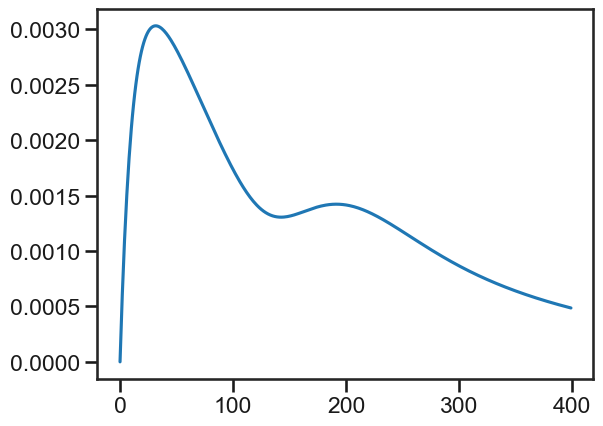

In [23]:
diffs_nico = [np.linalg.norm(w - a) for (w, a) in zip(ws, analytical)]
plt.plot(diffs_nico)

In [128]:
len(analytical)

400

In [121]:
ws

[Array([[[ 0.02071534, -0.5133457 , -0.05214217, -0.406197  ,
           0.25240126],
         [ 0.0929264 , -0.1401733 , -0.08809294,  0.18630071,
           0.14376298]]], dtype=float32),
 Array([[[-0.03217082, -0.4744248 , -0.04858527, -0.31990743,
           0.21748896],
         [ 0.08202142, -0.15105382, -0.07973506,  0.19629937,
           0.13991827]]], dtype=float32),
 Array([[[-0.07300884, -0.45085424, -0.04639634, -0.25587243,
           0.19359332],
         [ 0.07097303, -0.16426311, -0.07189824,  0.20558615,
           0.13732287]]], dtype=float32),
 Array([[[-0.10741208, -0.43758246, -0.04491557, -0.20496085,
           0.17644824],
         [ 0.05916423, -0.17917384, -0.06438366,  0.21508339,
           0.13540056]]], dtype=float32),
 Array([[[-0.13851137, -0.4317351 , -0.043754  , -0.1621163 ,
           0.1636374 ],
         [ 0.04626213, -0.19534898, -0.05703929,  0.2252764 ,
           0.13377163]]], dtype=float32),
 Array([[[-0.1681807 , -0.43145993, -0.04265738, -

In [120]:
analytical

array([[[ 0.02071533, -0.51334572, -0.05214217, -0.40619702,
          0.25240122],
        [ 0.09292639, -0.14017328, -0.08809294,  0.1863007 ,
          0.14376297]],

       [[-0.02921182, -0.48133523, -0.0493079 , -0.32763217,
          0.22174063],
        [ 0.08221284, -0.15211257, -0.08004028,  0.19573508,
          0.14060782]],

       [[-0.06969339, -0.46117581, -0.04740068, -0.26622669,
          0.19955383],
        [ 0.07107125, -0.16586808, -0.07237978,  0.20501518,
          0.13832023]],

       ...,

       [[-0.77173723, -0.40727007, -0.04924498,  0.42019419,
         -0.04184607],
        [-0.17814513, -0.45440384,  0.20687683,  0.40710626,
          0.01394938]],

       [[-0.77173723, -0.40727007, -0.04924498,  0.4201942 ,
         -0.04184607],
        [-0.17814514, -0.45440384,  0.20687683,  0.40710626,
          0.01394938]],

       [[-0.77173723, -0.40727007, -0.04924498,  0.4201942 ,
         -0.04184607],
        [-0.17814514, -0.45440384,  0.20687684,  0.40

In [103]:
ws[0]

array([[[-0.17520757, -0.464816  ,  0.3388471 , -0.11835613,
         -0.98585935],
        [ 0.07670934, -0.14333079, -0.45425403,  0.01687349,
          0.30569443]]])

In [100]:
analytical[0]

array([[-0.77173735, -0.40727007, -0.04924487,  0.42019423, -0.04184613],
       [-0.17814518, -0.45440393,  0.20687684,  0.4071062 ,  0.01394939]])

In [99]:
init_w2 @ init_w1

array([[-0.77173735, -0.40727007, -0.04924487,  0.42019423, -0.04184613],
       [-0.17814518, -0.45440393,  0.20687684,  0.4071062 ,  0.01394939]])

In [41]:
len(analytical)

400

In [59]:
analytical[0]

array([[-0.77173733, -0.40727007, -0.04924489,  0.42019418, -0.04184613],
       [-0.17814516, -0.45440395,  0.20687683,  0.40710618,  0.01394939]])

In [54]:
ws[0].shape

(1, 2, 5)

In [40]:
len(ws)

400

In [70]:
diffs = [np.linalg.norm(a - w) for (a, w) in zip(analytical, ws)]

In [77]:
first = [a[3][0] for a in analytical]

IndexError: index 3 is out of bounds for axis 0 with size 2

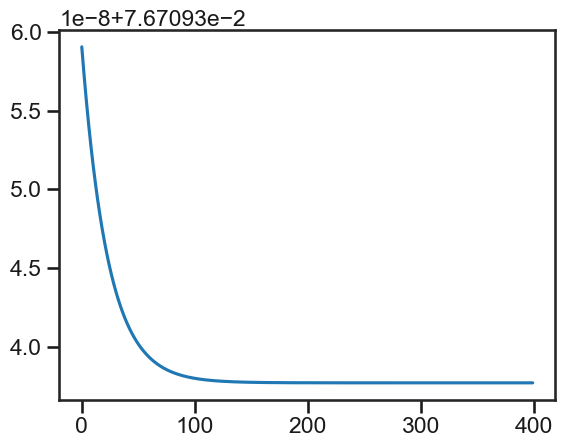

In [78]:
plt.plot(first)

In [71]:
diffs

[5.785660389243859e-16,
 3.988000709867804e-09,
 7.807629519537393e-09,
 1.1466003548731984e-08,
 1.4969937705315687e-08,
 1.8325957813774027e-08,
 2.1540312755641808e-08,
 2.4618986776942108e-08,
 2.7567710421977186e-08,
 3.039197188809875e-08,
 3.309702694463911e-08,
 3.568790910540397e-08,
 3.816943901213994e-08,
 4.054623336316441e-08,
 4.2822713855572214e-08,
 4.5003115317988116e-08,
 4.709149355279762e-08,
 4.909173313640887e-08,
 5.1007554408166575e-08,
 5.2842520760929624e-08,
 5.460004484440581e-08,
 5.628339550312345e-08,
 5.789570330264817e-08,
 5.94399667954598e-08,
 6.091905780868182e-08,
 6.233572697515845e-08,
 6.369260883168903e-08,
 6.499222678822208e-08,
 6.623699750493388e-08,
 6.742923577247276e-08,
 6.857115878449868e-08,
 6.966488988065743e-08,
 7.071246301612336e-08,
 7.171582616472338e-08,
 7.26768451533127e-08,
 7.35973069980949e-08,
 7.447892334174517e-08,
 7.532333364402854e-08,
 7.613210792901368e-08,
 7.690675032491058e-08,
 7.764870113195943e-08,
 7.835934

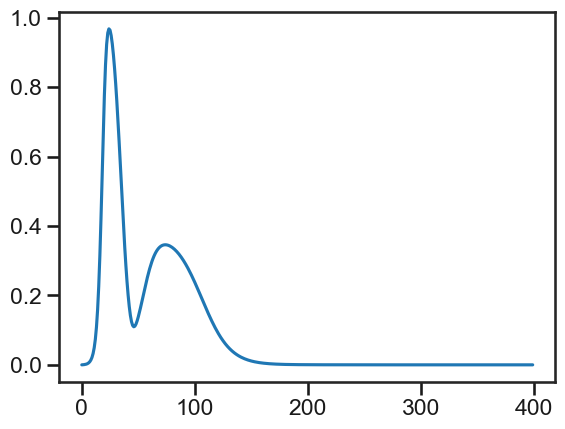

In [21]:
plt.plot(diffs)